<a href="https://colab.research.google.com/github/akm2208/Aayushi-First-Files/blob/main/Scatter_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount("/content/drive")

!pip install git+https://github.com/OpenHydrology/lmoments3.git
!pip install cftime
!pip install netCDF4


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import lmoments3 as lm
from lmoments3 import distr
import pandas as pd
import netCDF4 as nc
import glob
import os
import cftime
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # Import scipy.stats for the GEV distribution

# Load historical and future datasets
historical_fn = "/content/drive/My Drive/CIVE5363_Midterm_Q2bii/tas_day_CanESM5_historical_r1i1p1f1_gn_18500101-20141231.nc"
historical_ds = xr.open_dataset(historical_fn, engine="netcdf4")

future_fn = "/content/drive/My Drive/CIVE5363_Midterm_Q2bii/tas_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc"
future_ds = xr.open_dataset(future_fn, engine="h5netcdf")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/OpenHydrology/lmoments3.git to /tmp/pip-req-build-m6ylitfw
  Running command git clone --filter=blob:none --quiet https://github.com/OpenHydrology/lmoments3.git /tmp/pip-req-build-m6ylitfw
  Resolved https://github.com/OpenHydrology/lmoments3.git to commit 7e19f97c23019ca68cbd526b8bd417c412438f1c
  Preparing metadata (setup.py) ... done


In [63]:
lat = 35.8
lon = -91

historical_data = historical_ds.sel(lat=lat, lon=lon, method='nearest')
future_data = future_ds.sel(lat=lat, lon=lon, method='nearest')

In [64]:
# Define your GEV functions
def gev_wrapper(data, T):
    gevfit = gev_fit(data)
    RL = return_levels(gevfit, T)
    return RL

def gev_fit(data):
    gevfit = stats.genextreme.fit(data)
    return gevfit

def return_levels(gevfit, T):
    RL = stats.genextreme.ppf(1.0 - 1.0 / T, *gevfit)
    return RL

In [68]:
historical_data = historical_ds['tas'].values - 273.15
future_data = future_ds['tas'].values - 273.15



In [69]:
print(historical_data)

[[[-23.019241 -23.272781 -23.653702 ... -22.089386 -22.44661  -22.681122]
  [-23.569305 -24.120209 -24.707901 ... -21.672333 -22.349136 -22.970856]
  [-24.159637 -24.61943  -25.007965 ... -21.790695 -22.827896 -23.52893 ]
  ...
  [-20.289612 -17.75203  -15.228424 ... -26.817108 -24.893219 -22.688889]
  [-22.086288 -20.847977 -19.612305 ... -25.685837 -24.543167 -23.33664 ]
  [-24.238052 -23.974182 -23.70491  ... -25.091904 -24.802002 -24.537674]]

 [[-22.32463  -22.594238 -22.813004 ... -21.648544 -21.873291 -22.235672]
  [-24.462738 -25.070465 -25.748459 ... -22.509445 -23.21582  -23.836304]
  [-25.851334 -26.444672 -26.840973 ... -23.438385 -24.31842  -25.055054]
  ...
  [-19.979279 -17.20691  -14.560394 ... -27.328232 -25.163986 -22.661057]
  [-19.366196 -17.615524 -15.912903 ... -24.583588 -22.898865 -21.147308]
  [-19.313263 -18.712662 -18.11493  ... -21.113464 -20.53334  -19.920395]]

 [[-21.911407 -22.175201 -22.40416  ... -21.39383  -21.606735 -21.696182]
  [-24.487503 -25.1328

In [71]:
print(future_data)

[[[-20.254929  -20.434753  -20.616196  ... -19.632645  -19.838684
   -20.049164 ]
  [-21.359879  -21.552963  -21.739288  ... -20.311157  -20.757187
   -21.099106 ]
  [-23.626617  -23.800583  -23.899734  ... -22.271484  -22.92305
   -23.336136 ]
  ...
  [-28.025284  -28.3667    -28.6837    ... -27.12465   -27.391174
   -27.62642  ]
  [-29.694351  -29.681229  -29.549484  ... -30.15033   -30.091629
   -30.11264  ]
  [-25.005234  -24.630615  -24.33136   ... -25.991348  -25.784668
   -25.319595 ]]

 [[-20.268265  -20.443848  -20.463318  ... -19.770813  -19.93657
   -20.08397  ]
  [-21.973846  -22.255875  -22.374481  ... -20.763138  -21.304733
   -21.78299  ]
  [-23.746216  -23.919937  -24.104294  ... -22.54126   -23.117859
   -23.374237 ]
  ...
  [-29.648895  -29.56308   -29.418793  ... -28.97789   -29.326828
   -29.496796 ]
  [-26.733978  -26.654755  -26.556503  ... -27.19519   -27.065994
   -26.959518 ]
  [-20.08847   -20.012512  -19.955887  ... -20.366562  -20.253494
   -20.155472 ]]

 [

In [72]:
import numpy as np

# Flatten the data using block maxima for historical and future data
block_size = 365  # Block size for one year
num_blocks = historical_data.shape[0] // block_size

historical_maxima = []
future_maxima = []

for i in range(num_blocks):
    start_idx = i * block_size
    end_idx = (i + 1) * block_size
    historical_block = historical_data[start_idx:end_idx]
    future_block = future_data[start_idx:end_idx]

    if len(historical_block) > 0:
        historical_maxima.append(historical_block.max())

    if len(future_block) > 0:
        future_maxima.append(future_block.max())

# Calculate the 100-year return period
T = 100
historical_maxima = np.array(historical_maxima)
future_maxima = np.array(future_maxima)

historical_return_level = np.percentile(historical_maxima, 100 * (1 - 1 / T))
future_return_level = np.percentile(future_maxima, 100 * (1 - 1 / T))

print(f"100-year return level for historical data: {historical_return_level:.2f} °C")
print(f"100-year return level for future data: {future_return_level:.2f} °C")


100-year return level for historical data: 44.78 °C
100-year return level for future data: 53.59 °C


In [73]:
# Calculate return levels for historical and future data
T = 100  # Return period of 100 years
historical_return_levels = gev_wrapper(historical_maxima, T)
future_return_levels = gev_wrapper(future_maxima, T)

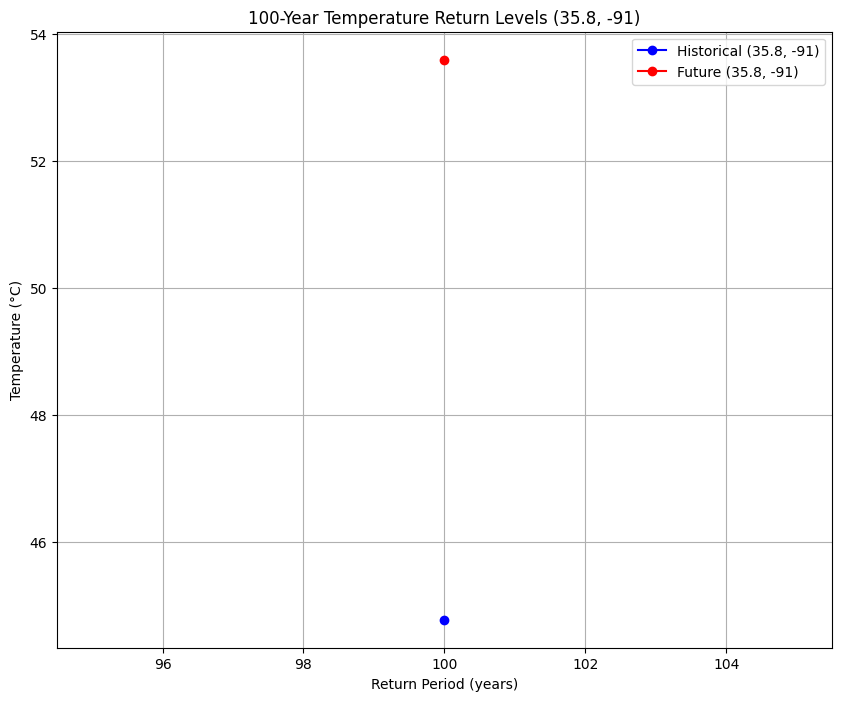

In [83]:
import matplotlib.pyplot as plt

# Define the return periods (in this case, just 100 years)
return_periods = [100]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot historical and future return levels as lines
ax.plot(return_periods, [historical_return_level], label='Historical (35.8, -91)', marker='o', color='blue')
ax.plot(return_periods, [future_return_level], label='Future (35.8, -91)', marker='o', color='red')

# Set labels and title
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('100-Year Temperature Return Levels (35.8, -91)')

# Add a legend
ax.legend()

# Add a grid
ax.grid()

# Display the plot
plt.show()
